In [1]:
import numpy as np
from scipy import stats

# Loading the given values
muEin = 1.74
muNew = 0.87

stdEdd= 0.4
stdCro = 0.16

xEdd = 1.61
xCro = 1.98

# Calculating the conditonal probabilities
PrM1 = stats.norm.pdf(xCro, muNew, stdCro) * stats.norm.pdf(xEdd, muNew, stdEdd)
PrM2 = stats.norm.pdf(xCro, muEin, stdCro) * stats.norm.pdf(xEdd, muEin, stdEdd)

print('Bayes Factor :', (PrM1/PrM2))


Bayes Factor : 2.0762126610332088e-11


# Problem 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
import emcee
 
# Reading the data from local computer
data = pd.read_csv('data.csv')
X = data['x'][4:]
Y = data['y'][4:]

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')

In [3]:
def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

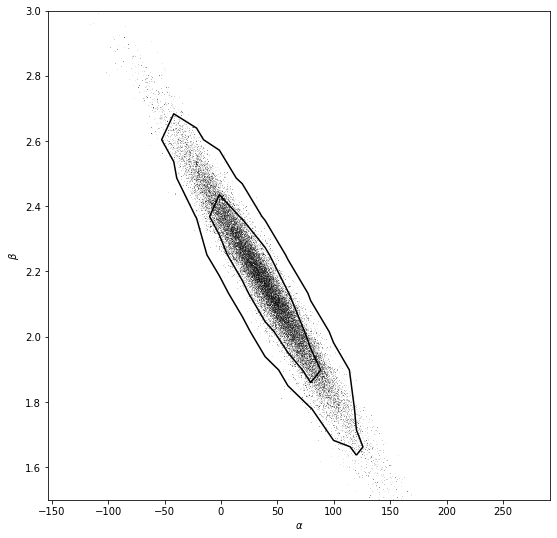

In [4]:
ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X, Y])
sampler.run_mcmc(starting_guesses, nsteps)

emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T

fig, ax = plt.subplots(figsize=(9,9))
plot_MCMC_trace(ax, X, Y, emcee_trace, True, colors= 'k')
ax.set_ylim(1.5, 3.0)
plt.show()

# Problem 3

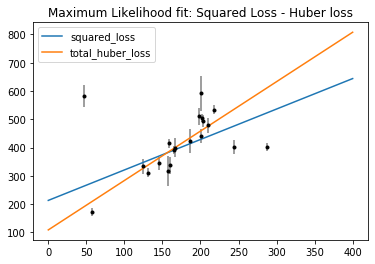

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import emcee
 
# Reading the data from local computer
data = pd.read_csv('data.csv')
X = np.array(data['x'], dtype=float)
Y = np.array(data['y'], dtype=float)
sigmaY = np.array(data['sigma_y'], dtype=float)

def squared_loss(theta, x = X, y = Y, e = sigmaY):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

t = np.linspace(-20, 20)

def huber_loss(t, c = 3):
    return ((abs(t) < c) * 0.5 * t ** 2 + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, x=X, y=Y, e=sigmaY, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()


theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

xfit = np.linspace(0, 400)
plt.errorbar(X, Y, sigmaY, fmt = '.k', ecolor = 'gray')
plt.plot(xfit, theta1[0] + (theta1[1] * xfit), label = 'squared_loss')
plt.plot(xfit, theta2[0] + (theta2[1] * xfit), label = 'total_huber_loss')
plt.legend(loc = 'best', fontsize = 10)
plt.title('Maximum Likelihood fit: Squared Loss - Huber loss')
plt.show()

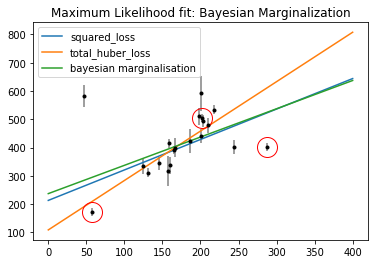

In [6]:
np.seterr(divide = 'ignore')

def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)


# Note that this step will take a few minutes to run!

ndim = 2 + len(X)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X, Y, sigmaY, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.38)

plt.errorbar(X, Y, sigmaY, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, label = 'squared_loss')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, label = 'total_huber_loss')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, label = 'bayesian marginalisation')
plt.legend(loc = 'best', fontsize = 10)
plt.plot(X[outliers], Y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Maximum Likelihood fit: Bayesian Marginalization');